# 状態空間モデル

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import pymc as pm
import arviz as az
import xarray as xr
from patsy import dmatrix

In [3]:
filepath = "../../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath)
df = df.dropna()

## 変数の定義

In [25]:
pivot_population = df.pivot_table(index="year", columns="island_id", values="population")
n_islands = df['island_id'].nunique()
n_year = df["year"].nunique()

## モデルの定義

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


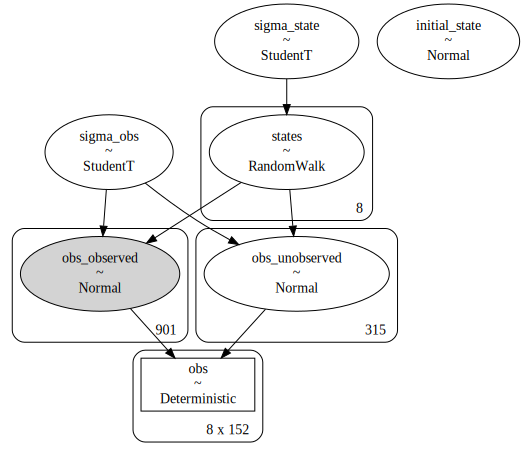

In [31]:
with pm.Model() as model:
    # 観測誤差の標準偏差
    sigma_obs = pm.StudentT("sigma_obs", nu=3, sigma=100)

    # 状態の標準偏差
    sigma_state = pm.StudentT("sigma_state", nu=3, sigma=100)

    # 初期状態
    initial_state = pm.Normal("initial_state", mu=0, sigma=100)

    # 状態の遷移
    states = pm.GaussianRandomWalk("states", mu=0, sigma=sigma_state, shape=n_year)

    # 観測モデル
    observations = pm.Normal("obs", mu=states, sigma=sigma_obs, observed=pivot_population, shape=(n_year, n_islands))

graph = pm.model_to_graphviz(model)
display(graph)

In [32]:
with model:
    idata = pm.sample(draws=2000, tune=1000, chains=4, nuts_sampler='numpyro')

IndexError: index 8 is out of bounds for axis 1 with size 8
Apply node that caused the error: AdvancedSubtensor(ExpandDims{axis=0}.0, 0, [  0   5 ... 4  87  49])
Toposort index: 8
Inputs types: [TensorType(float64, shape=(1, 8)), TensorType(int64, shape=()), TensorType(int64, shape=(315,))]
Inputs shapes: [(1, 8), (), (315,)]
Inputs strides: [(64, 8), (), (8,)]
Inputs values: ['not shown', array(0), 'not shown']
Outputs clients: [[SpecifyShape(AdvancedSubtensor.0, 315)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_57055/2082787850.py", line 15, in <module>
    observations = pm.Normal("obs", mu=states, sigma=sigma_obs, observed=pivot_population, shape=(n_year, n_islands))
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 510, in __new__
    rv_out = model.register_rv(
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py", line 1309, in register_rv
    rv_var = self.make_obs_var(
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py", line 1370, in make_obs_var
    ) = create_partial_observed_rv(rv_var, mask)
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 791, in create_partial_observed_rv
    unobserved_rv = local_subtensor_rv_lift.transform(fgraph, masked_rv.owner)[masked_rv]

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.